In [117]:
#Hello! Welcome to my Machine Learning Project focused around a German Credit data-set. 

**Data Background**

The global financial crisis of 2007-2008 has highlighted the importance of transparency and rigor in
banking practices. As the availability of credit has been limited, banks are increasingly tightening
their lending systems and turning to machine learning to more accurately identify risky loans.In this
section, you will develop a simple credit approval model using decision trees. We will also see how
the results of the model can be tuned to minimize errors that result in a financial loss for the
institution.
The credit dataset includes 1,000 examples of loans, plus a combination of numeric and nominal
features indicating characteristics of the loan and the loan applicant. A class variable indicates
whether the loan went into default.

As a CEO of a new German credit lender, I also want to figure out 2 things
    #1. What is the #1 cause of people defaulting on their loans?
    #2. What is the most accurate model I should deploy to track this?

Lastly, the Data Dictionary will be at the end of this project. Happy Reading! 

In [53]:
# First, I will read the CSV file into a DataFrame
import pandas as pd
credit = pd.read_csv("C:/Users/sanja/Downloads/credit.csv")

In [54]:
credit.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,A11,6,A34,A43,1169,A65,A75,4,4,67,A143,A152,2,A173,1,A192,no
1,A12,48,A32,A43,5951,A61,A73,2,2,22,A143,A152,1,A173,1,A191,yes
2,A14,12,A34,A46,2096,A61,A74,2,3,49,A143,A152,1,A172,2,A191,no
3,A11,42,A32,A42,7882,A61,A74,2,4,45,A143,A153,1,A173,2,A191,no
4,A11,24,A33,A40,4870,A61,A73,3,4,53,A143,A153,2,A173,2,A191,yes


In [55]:
credit.shape

(1000, 17)

In [67]:
#My target variable (Default), is in the 17th column, so I will use the 16 columns before to try and find my answers
X = pd.get_dummies(credit.iloc[: , 0:16] , drop_first = True)
y = credit.iloc[:, 16]

In [68]:
#Importing my Label-Encoder 
from sklearn.preprocessing import LabelEncoder
labelencoder_credit = LabelEncoder()
y = labelencoder_credit.fit_transform(credit['default'].values)

In [69]:
#Setting up my model so that it trains on a %20-%80 test-to-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state = 0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_pred, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.680


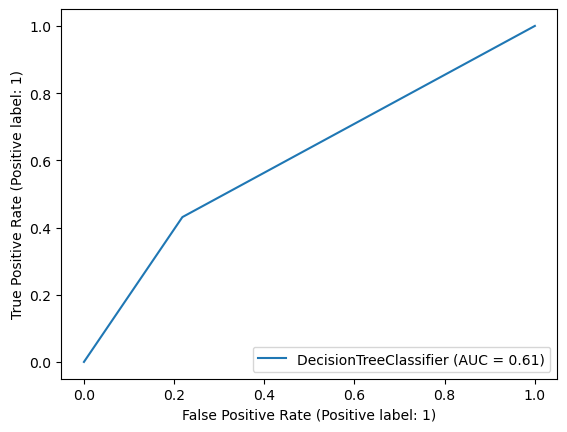

In [71]:
#As you see below, the .61 out of 1.00 shows that this model does not perform very well (.75 is where we'd like to be)
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(tree, X_test, y_test)

In [72]:
#Now were going to work on implementing cross validation to try and stabilize and improve the model.
#What is cross validation you ask? Cross-validation is a robust statistical technique for assessing how well a model generalizes to new data. 
#Instead of a single split into a training and test set, cross-validation involves multiple splits, and several models are trained. 
#The popular method is k-fold cross-validation, with the user choosing a value for k, often 5 or 10, here I chose 5.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree, X, y, cv= 5)
print("Accuracy scores of each fold: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Accuracy scores of each fold: [0.7   0.725 0.615 0.66  0.68 ]
Average cross-validation score: 0.68


**Next I will introduce some Ensemble Methods**

*What is an ensebmle method?*

An ensemble combines multiple supervised models into a “super-model.” An ensemble is based on the powerful notion of combining models. Instead of choosing a single predictive model, you can combine several models to achieve improved predictive accuracy. Below will be three Emsemble Methods: Bagging, Boosting and Random Forest.

**Ensebmble Method 1: Bagging**

Bagging, short for “bootstrap aggregating,” comprises two steps:

    1.Generate multiple random samples (by sampling with replacement from the original data)—this method is called “bootstrap sampling.”
    2.Running an algorithm on each sample and producing scores.

Bagging improves the performance stability of a model and helps avoid overfitting by separately modeling different data samples and then combining the results.

In [76]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(n_estimators=100, random_state=0)
bagging.fit(X_train, y_train)
y_bagging_pred = bagging.predict(X_test)
print("Bagging Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test,y_bagging_pred)))

Bagging Model Accuracy on test set: 0.770


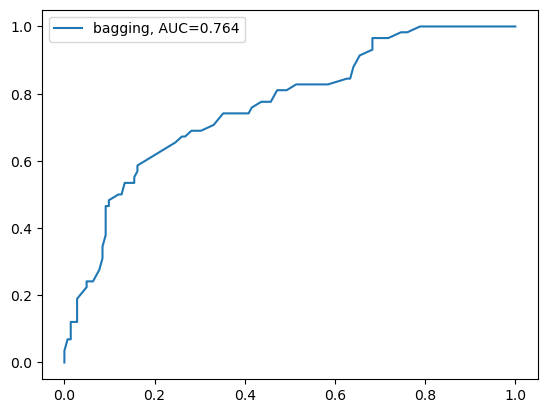

In [105]:
#Now, below is the visualization. As you can see, we have an uptick in the AUC (Area under the curve!)  
y_pred_prob_bagging = bagging.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob_bagging)
auc_tree = round(metrics.roc_auc_score(y_test, y_pred_prob_bagging), 3)
plt.plot(fpr1,tpr1,label="bagging, AUC="+str(auc_tree))
plt.legend()

In [107]:
#Next we have the next ensemble method, the Boosting Model

**Ensebmble Method 2: Boosted model**

Boosting is a slightly different approach to creating ensembles. Here the goal is to directly improve areas in the data where our model makes errors, by forcing the model to pay more attention to those records. The steps in boosting are:

    1.Fit a model to the data.
    2.Draw a sample from the data so that misclassified records (or records with large prediction errors) have higher probabilities of selection.
    3.Fit the model to the new sample.
    4.Repeat Steps 2–3 multiple times.

In [84]:
#This line of code calculates the accuracy of predictions made by an AdaBoostClassifier on the test set.
#Look at that AUC increasing (interesting how it's higher on test set, but this can happen)! 
from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier(n_estimators=100, random_state=0)
   
boost.fit(X_train, y_train)
y_boost_pred = boost.predict(X_test)
    
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_boost_pred, y_test)))

Accuracy on test set: 0.770


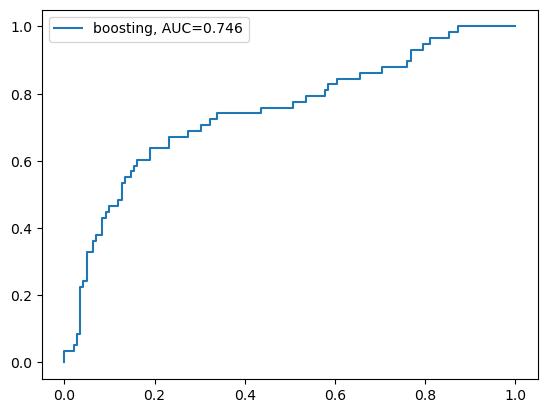

In [86]:
y_pred_prob_boosting = boost.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob_boosting)
auc_tree = round(metrics.roc_auc_score(y_test, y_pred_prob_boosting), 3)
plt.plot(fpr1,tpr1,label="boosting, AUC="+str(auc_tree))
plt.legend()

**Ensebmble Method 3: Random Forest**

The basic idea in random forests is to:

    1. Draw multiple random samples, with replacement, from the data (this sampling approach is called the bootstrap).
    2. Using a random subset of predictors at each stage, fit a classification (or regression) tree to each sample (and thus obtain a “forest”).
    3. Combine the predictions/classifications from the individual trees to obtain improved predictions. Use voting for classification and averaging for prediction.

In [100]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

y_rf_pred = forest.predict(X_test)
print("Random Forest Accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_rf_pred)))

Random Forest Accuracy on test set: 0.755


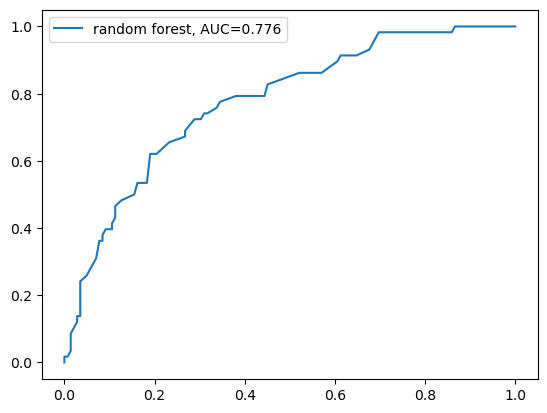

In [103]:
y_pred_prob_rf = forest.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob_rf)
auc_tree = round(metrics.roc_auc_score(y_test, y_pred_prob_rf), 3)
plt.plot(fpr1,tpr1,label="random forest, AUC="+str(auc_tree))
plt.legend()

In [116]:
importances = forest.feature_importances_

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
df = df.sort_values('importance')
print(df)

                    feature  importance
21              purpose_A48    0.001639
15             purpose_A410    0.003074
18              purpose_A44    0.003549
19              purpose_A45    0.005969
25      savings_balance_A64    0.007281
24      savings_balance_A63    0.009093
34             housing_A153    0.009370
31        other_credit_A142    0.009712
20              purpose_A46    0.010816
22              purpose_A49    0.011207
8      checking_balance_A13    0.012295
23      savings_balance_A62    0.012734
12       credit_history_A33    0.012787
37                 job_A174    0.013904
6                dependents    0.014020
29  employment_duration_A74    0.014317
35                 job_A172    0.014818
14              purpose_A41    0.015302
16              purpose_A42    0.017026
30  employment_duration_A75    0.017329
11       credit_history_A32    0.017518
10       credit_history_A31    0.018543
28  employment_duration_A73    0.018546
27  employment_duration_A72    0.018986


In [ ]:
#Now, lets see what variables have the highest impact on a customer defaulting by ranking them in order of importance.
#This is in Desc. order, and as you can tell, the amount of the loan is bt far the biggest reason customers default.

Now lets look at once last concept, **The Grid Search Concept**

Now that we know how to evaluate how well a model generalizes, we can take the next step and improve the model’s generalization performance by tuning its parameters.Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets.

Because it is such a common task, there are standard methods in scikit-learn to help you with it. The most commonly used method is grid search, which basically means trying all possible combinations of the parameters of interest.

In [108]:
import numpy as np
from sklearn.model_selection import GridSearchCV
params = {'criterion':['gini','entropy'],'max_leaf_nodes': list(range(2, 50)), 'max_depth': np.arange(3, 15)}
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...]})

In [109]:
tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=17, random_state=0)

In [110]:
y_pred_grid = tree_grid.predict(X_test)
print("Grid-search Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred_grid)))

Grid-search Model Accuracy on test set: 0.740


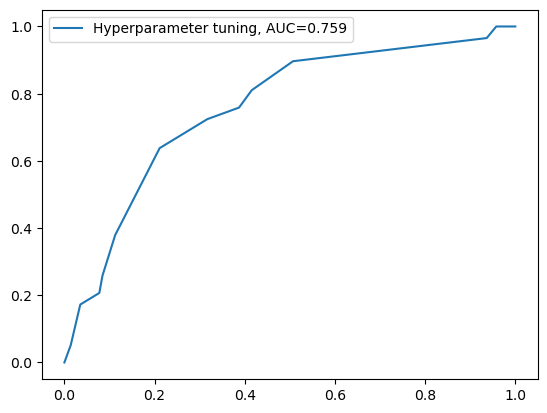

In [111]:
y_pred_prob_grid = tree_grid.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob_grid)
auc_tree = round(metrics.roc_auc_score(y_test, y_pred_prob_grid), 3)
plt.plot(fpr1,tpr1,label="Hyperparameter tuning, AUC="+str(auc_tree))
plt.legend()

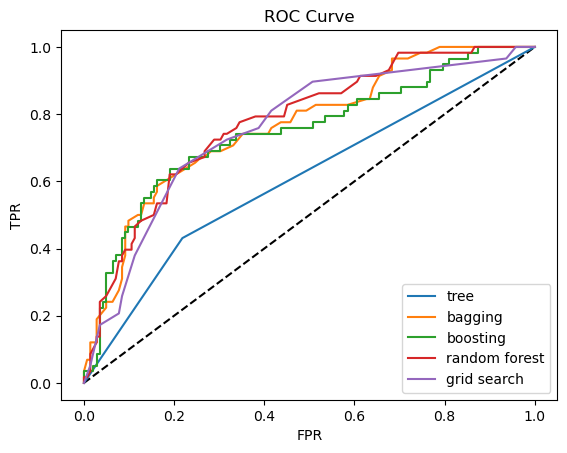

In [119]:
# Fit the decision tree model
tree.fit(X_train, y_train)
y_pred_prob_tree = tree.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob_tree)

#Visaulize the models compared to one another to see which is best! 
y_pred_prob_tree = tree.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob_tree)

y_pred_prob_bagging = bagging.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred_prob_bagging)


y_pred_prob_boosting = boost.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = metrics.roc_curve(y_test, y_pred_prob_boosting)

y_pred_prob_rf = forest.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = metrics.roc_curve(y_test, y_pred_prob_rf)

y_pred_prob_grid = tree_grid.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 = metrics.roc_curve(y_test, y_pred_prob_grid)



plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "tree")
plt.plot(fpr2, tpr2, label= "bagging")
plt.plot(fpr3, tpr3, label= "boosting")
plt.plot(fpr4, tpr4, label= "random forest")
plt.plot(fpr5, tpr5, label= "grid search")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve')
plt.show()

#And we have a winner! Just barely, the Random Forest method fit's this data-set the best. 

In [118]:
#Thanks for reading, I hope you enjoyed this project I did on German Credit Data!


**Data Dictionary:**

checking_balance: Status of existing checking account
A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account
months_loan_duration
credit_history

A30 : no credits taken/ all credits paid back duly

A31 : all credits at this bank paid back duly

A32 : existing credits paid back duly till now

A33 : delay in paying off in the past

A34 : critical account/ other credits existing (not at this bank)
purpose:


A40 : car (new)

A41 : car (used)

A42 : furniture/equipment

A43 : radio/television

A44 : domestic appliances

A45 : repairs

A46 : education

A47 : (vacation - does not exist?)

A48 : retraining

A49 : business

A410 : others

amount: credit amount

savings_balance :
A61 : ... < 100 DM

A62 : 100 <= ... < 500 DM

A63 : 500 <= ... < 1000 DM

A64 : .. >= 1000 DM

A65 : unknown/ no savings account

employment_duration: 
Present employment since
A71 : unemployed

A72 : ... < 1 year

A73 : 1 <= ... < 4 years

A74 : 4 <= ... < 7 years

A75 : .. >= 7 years

percent_of_income:

Installment rate in percentage of disposable income

years_at_residence

age

other_credit: Other installment plans

A141 : bank

A142 : stores

A143 : none

housing:

A151 : rent

A152 : own

A153 : for free

existing_loans_count: Number of existing credits at this bank

job:

A171 : unemployed/ unskilled - non-resident

A172 : unskilled - resident

A173 : skilled employee / official


A174 : management/ self-employed/highly qualified employee/ officer

dependents: Number of people being liable to provide maintenance for

phone:

A191 : none

A192 : yes, registered under the customer name
default : no and yes
